# Monte Carlo Methods


### Explore BlackjackEnv

In [1]:
import sys
import pdb

import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [2]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Play Blackjack with a random policy.

In [4]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(19, 3, False)
End game! Reward:  -1.0
You lost :(

(14, 10, False)
(16, 10, False)
End game! Reward:  -1
You lost :(

(5, 8, False)
End game! Reward:  -1.0
You lost :(



### MC Prediction  

Begin by investigating a policy where the player _almost_ always sticks if the sum of their cards exceeds 18. In particular, they select action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, they select action `HIT` with 80% probability.

The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state (tuple), action (int), reward (int)) tuples and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [5]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Play Blackjack with the policy described above.

In [6]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((13, 10, False), 1, -1)]
[((20, 10, True), 0, -1.0)]
[((6, 3, False), 1, 0), ((16, 3, False), 1, -1)]


In [7]:
episode = generate_episode_from_limit_stochastic(env)

Implementing MC prediction.

In [9]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    # when key is not found, `lambda: np.zeros(env.action_space.n)` automatically creates
    # array([ 0.,  0.]) entry for that key
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        episode = generate_episode(env)     
        states, actions, rewards = zip(*episode)
        
        discounts = np.array([gamma ** i for i in range(len(rewards) + 1)])
        
        for step, state in enumerate(states):
            returns_sum[state][actions[step]] += sum(rewards[step:] * discounts[:-(step+1)])
            N[state][actions[step]] += 1.0
            Q[state][actions[step]] = returns_sum[state][actions[step]] / N[state][actions[step]]
        
    return Q

Obtain the action-value function estimate $Q$.

Also plot the corresponding state-value function.

Episode 500000/500000.

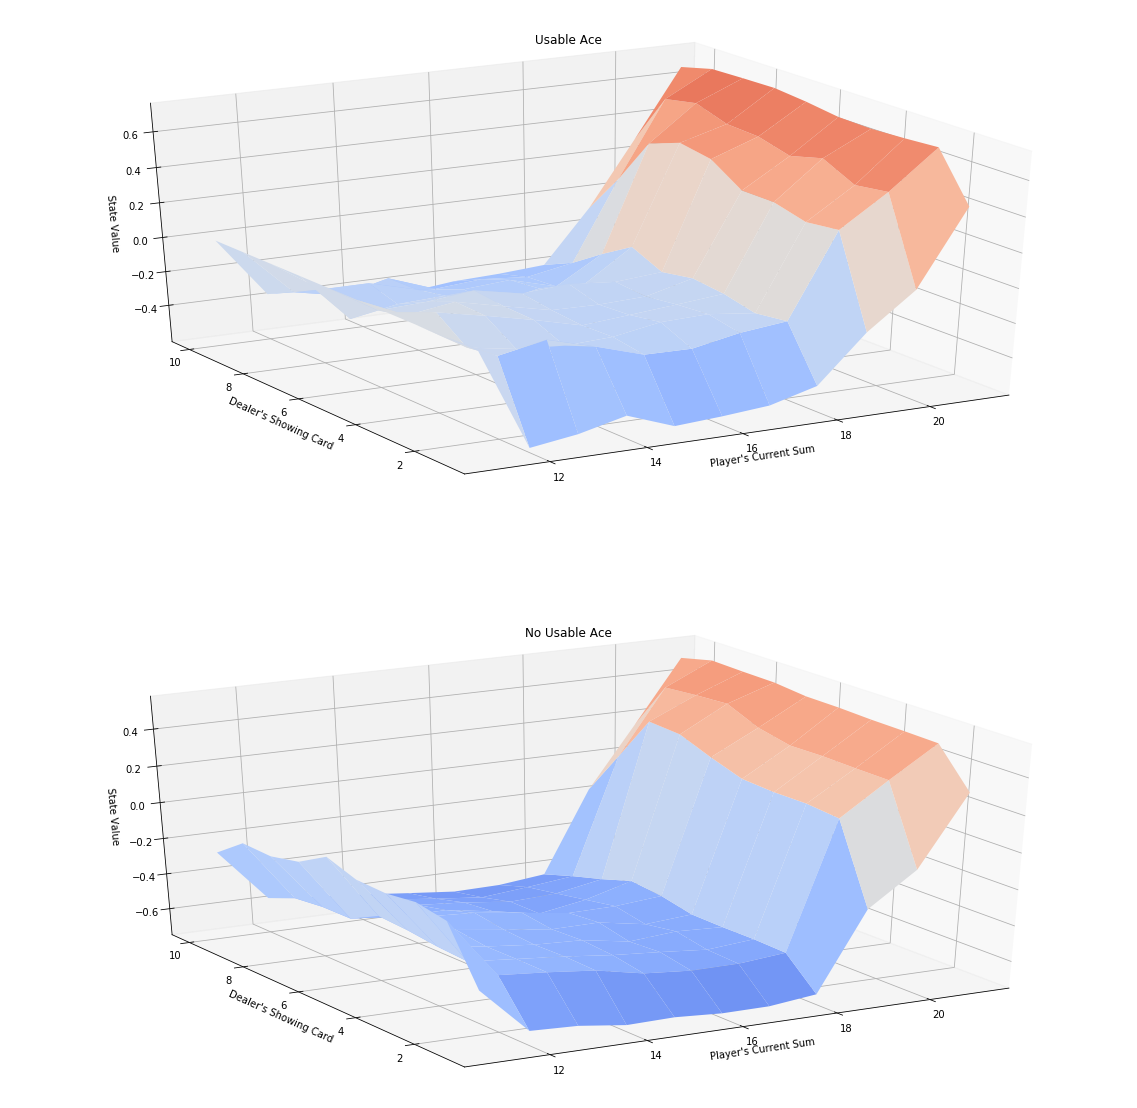

In [11]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### MC Control

Implementation of constant-$\alpha$ MC control.  

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [127]:
def get_probs(Q_s, epsilon, nA):
    probs = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q_s)
    probs[best_action] = 1 - epsilon + (epsilon / nA)
    
    return probs

def generate_episide_with_probs(env, Q, epsilon, nA):
    episode = []
    state = env.reset()

    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
            if state in Q else env.action_space.sample()
            
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
        
    return episode

In [152]:
def update_Q(episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma ** i for i in range(len(rewards) + 1)])
        
    for step, state in enumerate(states):
        old_Q = Q[state][actions[step]]
        reward = sum(rewards[step:]*discounts[:-(step+1)])
        Q[state][actions[step]] = old_Q + alpha * (reward - old_Q)

    return Q

def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.1):
    nA = env.action_space.n
    
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, eps_min)
        
        # Generate episode        
        episode = generate_episide_with_probs(env, Q, epsilon, nA)  
        
        # Update Q table
        Q = update_Q(episode, Q, alpha, gamma)
    
    policy = dict((k, np.argmax(v)) for k, v in Q.items())
        
    return policy, Q

Obtain the estimated optimal policy and action-value function.

In [153]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 1000000, 0.01)

Episode 1000000/1000000.

Next, plot the corresponding state-value function.

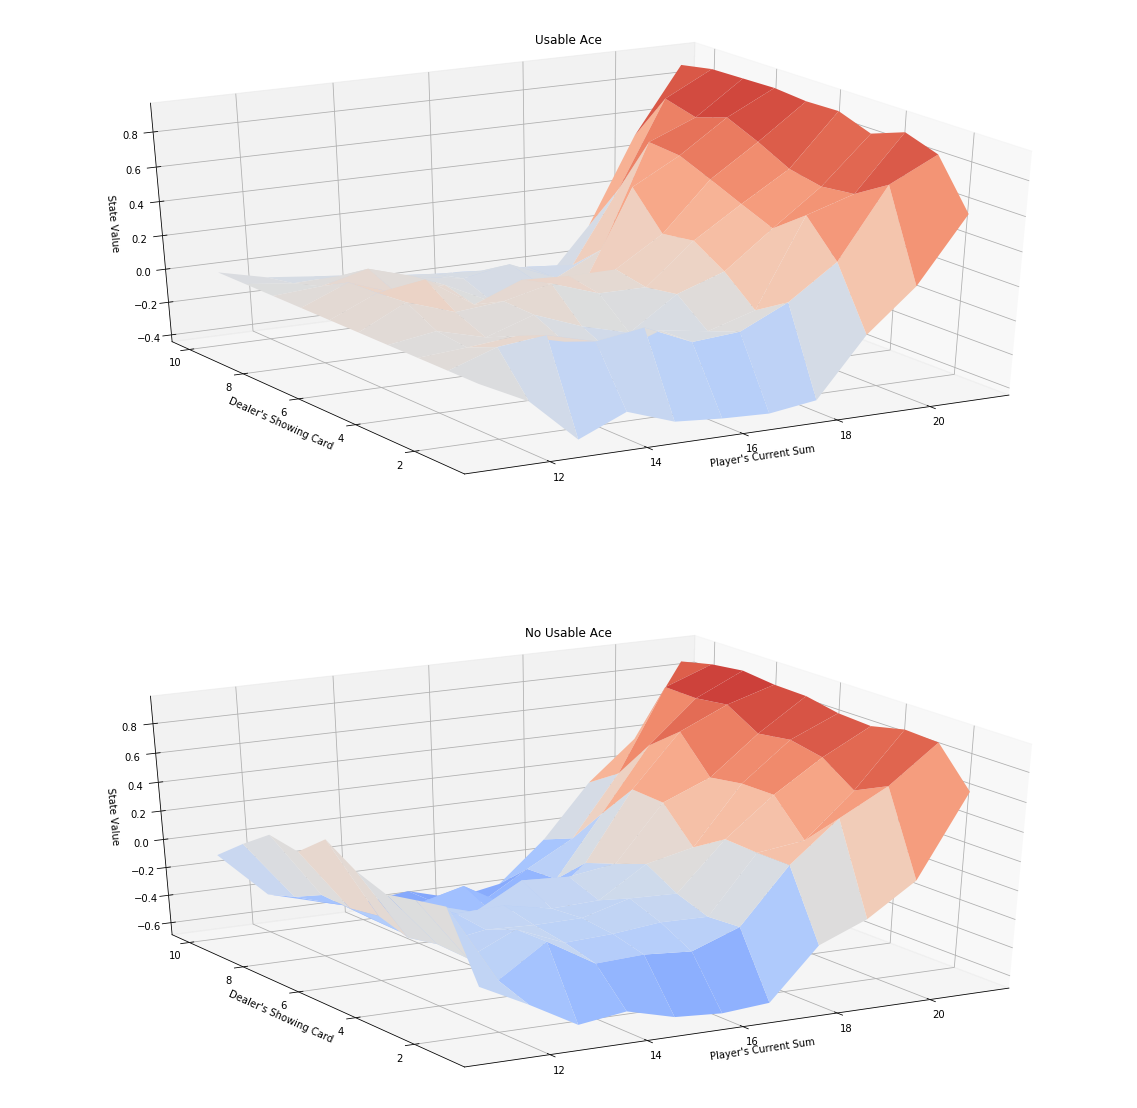

In [154]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, visualize the policy that is estimated to be optimal.

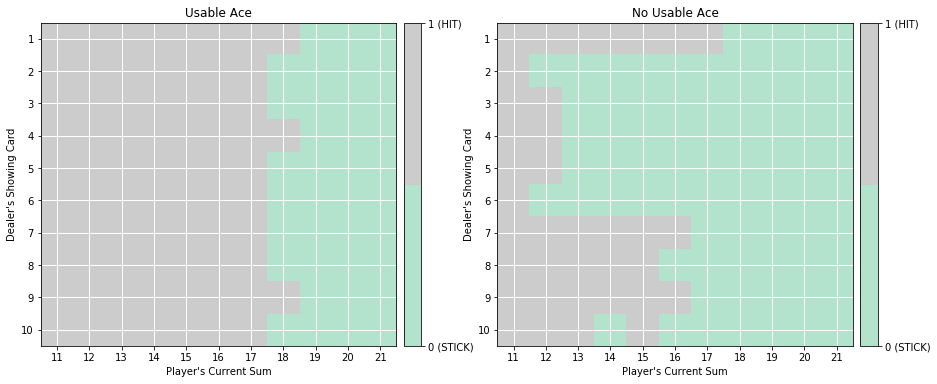

In [155]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (Sutton and Barto, 2018).